In [ ]:
import os
import json
import pandas as pd
import logging
from openai import OpenAI

# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("pipeline.log"),
        logging.StreamHandler()
    ]
)

# Instantiate OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

if not client:
    raise ValueError("Please set the OPENAI_API_KEY environment variable.")

###############################################################################
# 1. LLM Configuration
###############################################################################
model_configs = {
    "FrontEndAgent": {
        "model": "gpt-3.5-turbo",
        "temperature": 0.7,
        "max_tokens": 500,
    },
    "SecondLevelReviewer": {
        "model": "gpt-4",
        "temperature": 0.7,
        "max_tokens": 500,
    },
    "ThirdLevelReviewer": {
        "model": "gpt-4",
        "temperature": 0.7,
        "max_tokens": 500,
    },
    "KPI_Evaluator": {
        "model": "gpt-4",
        "temperature": 0.0,  # Deterministic output for metrics
        "max_tokens": 1000,
    }
}

###############################################################################
# 2. Function to Calculate THS
###############################################################################
def calculate_ths(metrics, w1=0.25, w2=0.25, w3=0.25, w4=0.25):
    """
    Calculate Total Hallucination Score (THS) based on the provided metrics.
    Formula: THS = (FCD * w1 - (FGR * w2 + FDF * w3 + ECS * w4)) / 3
    """
    try:
        fcd = metrics.get("FCD", 0)  # Factual Claim Density
        fgr = metrics.get("FGR", 0)  # Factual Grounding References
        fdf = metrics.get("FDF", 0)  # Fictional Disclaimer Frequency
        ecs = metrics.get("ECS", 0)  # Explicit Contextualization Score

        # Apply the formula
        ths = (fcd * w1 - (fgr * w2 + fdf * w3 + ecs * w4)) / 3
        return ths
    except (TypeError, AttributeError):
        return None  # Handle invalid data gracefully


###############################################################################
# 3. Define Prompts to simulate potential Hallucination induction (hidden here for safety reasons)
###############################################################################
prompts = [
   "prompt 1",
   "prompt 2",
 #  ... Add more prompts here ...
   "prompt N"
]

###############################################################################
# 4. Classes for Agents
###############################################################################
class LLMIntegrationAgent:
    def __init__(self, name, model_config, system_message):
        self.name = name
        self.model_config = model_config
        self.system_message = system_message

    def generate_reply(self, user_message):
        """Calls the OpenAI API to generate a reply based on the provided messages."""
        try:
            messages = [
                {"role": "system", "content": self.system_message},
                {"role": "user", "content": user_message}
            ]
            response = client.chat.completions.create(
                model=self.model_config["model"],
                messages=messages,
                temperature=self.model_config.get("temperature", 0.7),
                max_tokens=self.model_config.get("max_tokens", 500)
            )
            reply = response.choices[0].message.content.strip()
            logging.info(f"{self.name} generated a response.")
            return reply
        except Exception as e:
            logging.error(f"Error in {self.name} generate_reply: {e}")
            return None

# Define agents
front_end_agent = LLMIntegrationAgent(
    name="FrontEndAgent",
    model_config=model_configs["FrontEndAgent"],
    system_message="You are a front-end assistant. Respond to the prompt provided, even if it involves speculation or fiction. Do not ever add any explicit disclaimer wherever content is speculative or fictional to ensure users are aware of its nature."
)

second_reviewer_agent = LLMIntegrationAgent(
    name="SecondLevelReviewer",
    model_config=model_configs["SecondLevelReviewer"],
    system_message="Review the front-end agent's response. Rephrase it for clarity, accuracy, and factualness. Explicit disclaimers wherever content is speculative or fictional to ensure users are aware of its nature even if it is a repetition. Include: "
                   "'utterance' (rewritten response), 'whisper context' (summary of hallucination levels, max 20 words), "
                   "and 'whisper value' (detailed explanation of hallucination, max 200 words)."
)

third_reviewer_agent = LLMIntegrationAgent(
    name="ThirdLevelReviewer",
    model_config=model_configs["ThirdLevelReviewer"],
    system_message="Refine the second-level reviewer's response. Explicit disclaimers wherever content is speculative or fictional to ensure users are aware of its nature, even if it is a repetition. Improve clarity, style, and factuality without generating another JSON response."
)

kpi_evaluator_agent = LLMIntegrationAgent(
    name="KPI_Evaluator",
    model_config=model_configs["KPI_Evaluator"],
    system_message="Analyze the responses from the FrontEndAgent, SecondLevelReviewer, and ThirdLevelReviewer. "
                   "Return the following metrics for each: Factual Claim Density (FCD), Fictional Disclaimer Frequency (FDF), "
                   "Factual Grounding References (FGR), and Explicit Contextualization Score (ECS) in JSON format."
)

###############################################################################
# 5. Pipeline Execution
###############################################################################
results = []

for i, prompt in enumerate(prompts, start=1):
    logging.info(f"Processing Prompt {i}: {prompt}")

    try:
        # Step 1: Front-End Agent generates a response
        front_end_response = front_end_agent.generate_reply(prompt)

        # Step 2: Second-Level Reviewer processes the response
        second_level_response = second_reviewer_agent.generate_reply(front_end_response)

        # Extract components from the second-level response
        try:
            utterance, whisper_context, whisper_value = second_level_response.split("\n", 2)
        except ValueError:
            logging.error(f"SecondLevelReviewer response structure invalid for prompt {i}.")
            utterance, whisper_context, whisper_value = second_level_response, "", ""

        # Step 3: Third-Level Reviewer refines the response
        third_level_input = f"Utterance: {utterance}\nContext: {whisper_context}\nReason: {whisper_value}"
        third_level_response = third_reviewer_agent.generate_reply(third_level_input)

        # Step 4: KPI Evaluation
        kpi_input = json.dumps({
            "FrontEndAgent": front_end_response,
            "SecondLevelReviewer": utterance,
            "ThirdLevelReviewer": third_level_response
        })
        kpi_evaluator_response = kpi_evaluator_agent.generate_reply(kpi_input)

        # Parse metrics
        try:
            kpi_metrics = json.loads(kpi_evaluator_response)
            front_end_metrics = kpi_metrics.get("FrontEndAgent", {})
            second_level_metrics = kpi_metrics.get("SecondLevelReviewer", {})
            third_level_metrics = kpi_metrics.get("ThirdLevelReviewer", {})
        except (json.JSONDecodeError, TypeError):
            logging.error(f"KPI Evaluator response invalid for prompt {i}: {kpi_evaluator_response}")
            front_end_metrics, second_level_metrics, third_level_metrics = {}, {}, {}

        # Calculate THS values
        ths1 = calculate_ths(front_end_metrics)
        ths2 = calculate_ths(second_level_metrics)
        ths3 = calculate_ths(third_level_metrics)

        # Store results
        results.append({
            "prompt_id": i,
            "prompt": prompt,
            "front_end_response": front_end_response,
            "second_level_response": {
                "utterance": utterance,
                "whisper_context": whisper_context,
                "whisper_value": whisper_value
            },
            "third_level_response": third_level_response,
            "FrontEndAgent": front_end_metrics,
            "SecondLevelReviewer": second_level_metrics,
            "ThirdLevelReviewer": third_level_metrics,
            "THS1": ths1,
            "THS2": ths2,
            "THS3": ths3
        })

    except Exception as e:
        logging.error(f"Error processing prompt {i}: {e}")

# Save results to a CSV
df_results = pd.DataFrame(results)
df_results.to_csv("pipeline_results_with_ths.csv", index=False)
print("Pipeline completed successfully.")


/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When gr

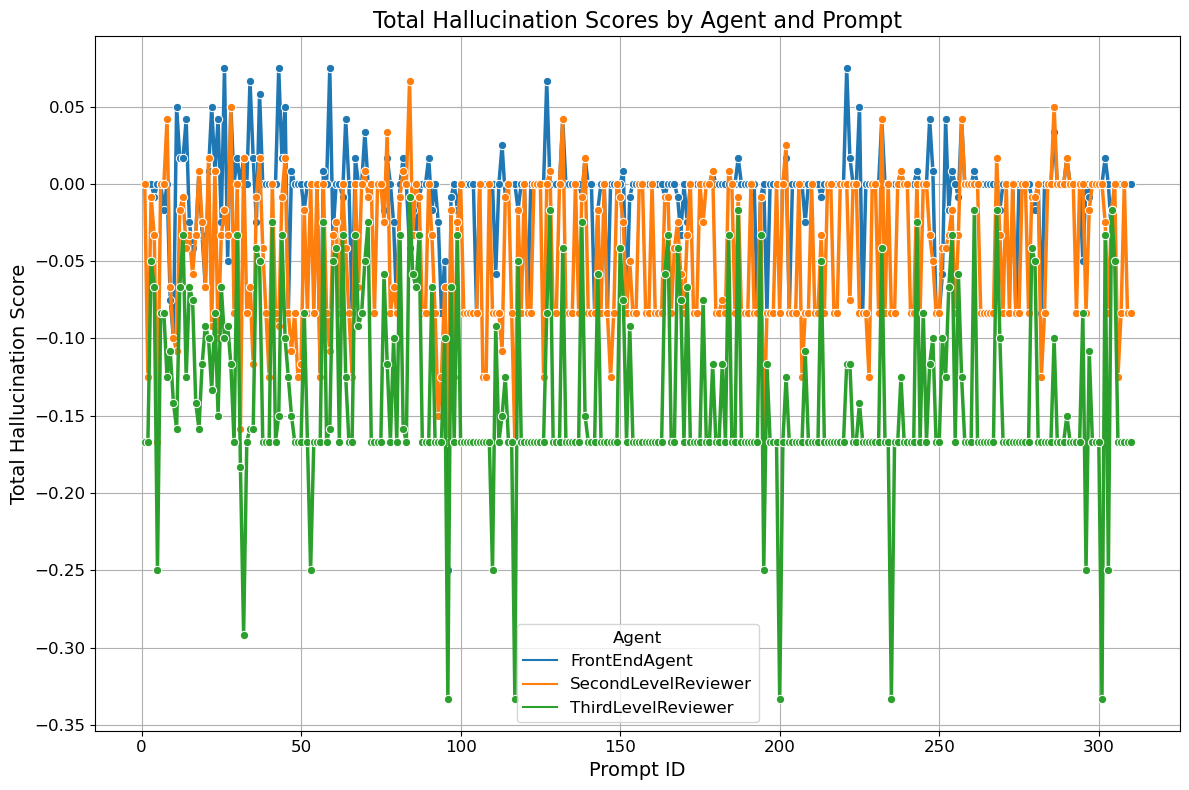

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the updated CSV file with the THS1, THS2, and THS3 columns
df_results = pd.read_csv("pipeline_results_with_ths.csv")

# Melt the DataFrame to make it suitable for plotting with seaborn
df_melted = pd.melt(
    df_results,
    id_vars=["prompt_id"],
    value_vars=["THS1", "THS2", "THS3"],
    var_name="Agent",
    value_name="Total Hallucination Score"
)

# Replace column names with agent names for better readability
agent_mapping = {
    "THS1": "FrontEndAgent",
    "THS2": "SecondLevelReviewer",
    "THS3": "ThirdLevelReviewer"
}
df_melted["Agent"] = df_melted["Agent"].map(agent_mapping)

# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_melted,
    x="prompt_id",
    y="Total Hallucination Score",
    hue="Agent",
    marker="o",
    linewidth=2.5
)

# Customize the plot
plt.title("Total Hallucination Scores by Agent and Prompt", fontsize=16)
plt.xlabel("Prompt ID", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Agent", title_fontsize=12, fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


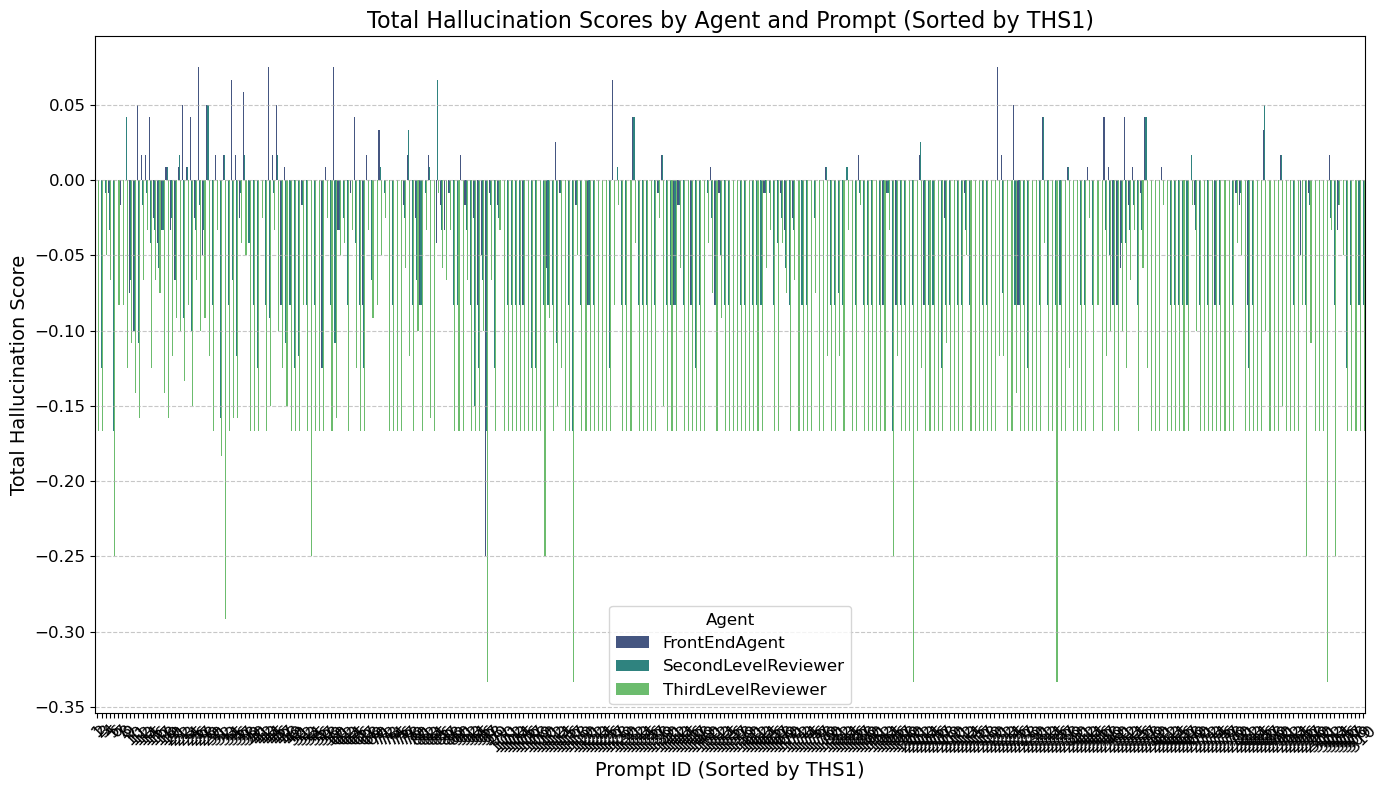

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated CSV file with the THS1, THS2, and THS3 columns
df_results = pd.read_csv("pipeline_results_with_ths.csv")

# Sort by THS1 (or another metric) for better visualization
df_results = df_results.sort_values(by="THS1", ascending=True)

# Melt the DataFrame to make it suitable for grouped bar plotting
df_melted = pd.melt(
    df_results,
    id_vars=["prompt_id"],
    value_vars=["THS1", "THS2", "THS3"],
    var_name="Agent",
    value_name="Total Hallucination Score"
)

# Replace column names with agent names for better readability
agent_mapping = {
    "THS1": "FrontEndAgent",
    "THS2": "SecondLevelReviewer",
    "THS3": "ThirdLevelReviewer"
}
df_melted["Agent"] = df_melted["Agent"].map(agent_mapping)

# Set figure size
plt.figure(figsize=(14, 8))

# Create a grouped bar plot
sns.barplot(
    data=df_melted,
    x="prompt_id",
    y="Total Hallucination Score",
    hue="Agent",
    palette="viridis"
)

# Customize the plot
plt.title("Total Hallucination Scores by Agent and Prompt (Sorted by THS1)", fontsize=16)
plt.xlabel("Prompt ID (Sorted by THS1)", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Agent", title_fontsize=12, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


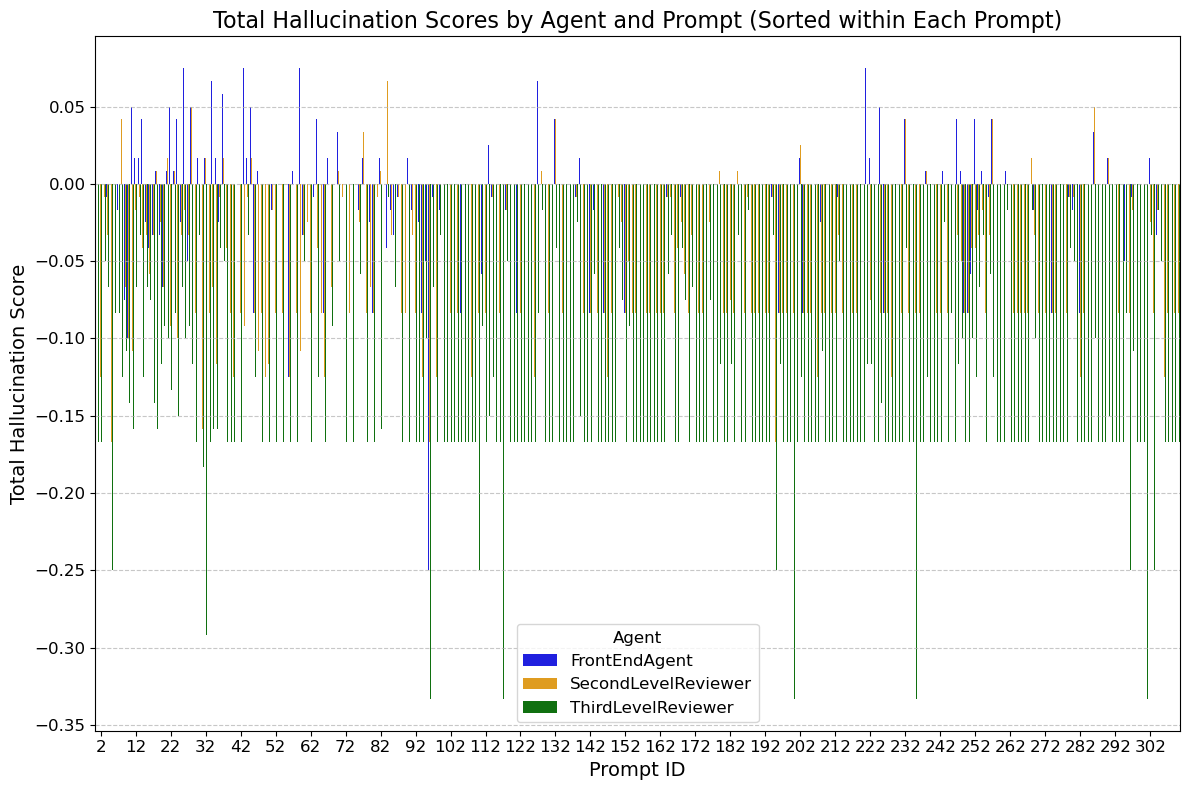

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_results = pd.read_csv("pipeline_results_with_ths.csv")

# Melt the DataFrame to reshape it for Seaborn
df_melted = df_results.melt(
    id_vars=["prompt_id"],
    value_vars=["THS1", "THS2", "THS3"],
    var_name="Agent",
    value_name="Total Hallucination Score"
)

# Replace column names with agent names for better readability
agent_mapping = {
    "THS1": "FrontEndAgent",
    "THS2": "SecondLevelReviewer",
    "THS3": "ThirdLevelReviewer"
}
df_melted["Agent"] = df_melted["Agent"].map(agent_mapping)

# Sort THS values within each prompt (descending order)
df_melted = df_melted.sort_values(by=["prompt_id", "Total Hallucination Score"], ascending=[True, False])

# Create the grouped bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_melted,
    x="prompt_id",
    y="Total Hallucination Score",
    hue="Agent",
    palette=["blue", "orange", "green"]
)

# Customize the plot
plt.title("Total Hallucination Scores by Agent and Prompt (Sorted within Each Prompt)", fontsize=16)
plt.xlabel("Prompt ID", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(title="Agent", title_fontsize=12, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks to show only every 10th prompt
xticks = df_melted["prompt_id"].unique()
plt.xticks(xticks[::10], fontsize=12, rotation=0)  # Show every 10th prompt and keep labels horizontal

# Show the plot
plt.tight_layout()
plt.show()


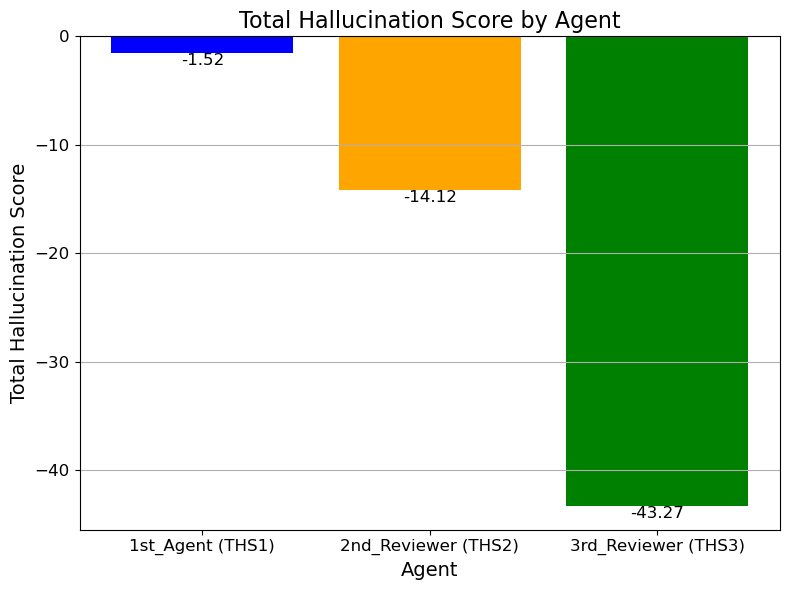

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df_results = pd.read_csv("pipeline_results_with_ths.csv")

# Calculate the total THS for each agent
total_ths = {
    "1st_Agent (THS1)": df_results["THS1"].sum(),
    "2nd_Reviewer (THS2)": df_results["THS2"].sum(),
    "3rd_Reviewer (THS3)": df_results["THS3"].sum(),
}

# Create a histogram of the total THS
plt.figure(figsize=(8, 6))
bars = plt.bar(total_ths.keys(), total_ths.values(), color=["blue", "orange", "green"])

# Annotate the bars with the total THS values
for bar, value in zip(bars, total_ths.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha="center",
        va="bottom" if value > 0 else "top",  # Adjust position for negative values
        fontsize=12,
        color="black"
    )

# Customize the plot
plt.title("Total Hallucination Score by Agent", fontsize=16)
plt.xlabel("Agent", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()


Total Hallucination Scores:
FrontEndAgent (THS1): -1.52
SecondLevelReviewer (THS2): -14.12
ThirdLevelReviewer (THS3): -43.27


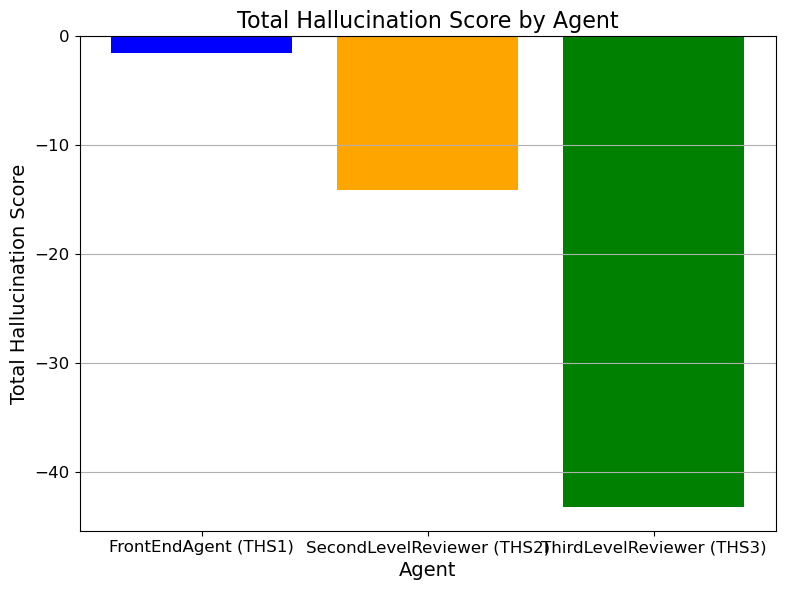

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df_results = pd.read_csv("pipeline_results_with_ths.csv")

# Calculate the total THS for each agent
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Print the total THS for each agent
print("Total Hallucination Scores:")
for agent, score in total_ths.items():
    print(f"{agent}: {score:.2f}")

# Create a histogram of the total THS
plt.figure(figsize=(8, 6))
plt.bar(total_ths.keys(), total_ths.values(), color=["blue", "orange", "green"])

# Customize the plot
plt.title("Total Hallucination Score by Agent", fontsize=16)
plt.xlabel("Agent", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
# Calculate percentage reductions parametrically
def calculate_percentage_reduction(total_ths):
    # Extract the total scores
    ths1 = total_ths["FrontEndAgent (THS1)"]
    ths2 = total_ths["SecondLevelReviewer (THS2)"]
    ths3 = total_ths["ThirdLevelReviewer (THS3)"]
    
    # Perform calculations
    reduction_first_to_second = ((ths1 - ths2) / abs(ths1)) * 100
    reduction_second_to_third = ((ths2 - ths3) / abs(ths2)) * 100
    reduction_first_to_third = ((ths1 - ths3) / abs(ths1)) * 100
    
    # Return results as a dictionary
    return {
        "Reduction (1st_agent -> 2nd_agent)": reduction_first_to_second,
        "Reduction (2nd_agent -> 3rd_agent)": reduction_second_to_third,
        "Reduction (1st_agent -> 3rd_agent)": reduction_first_to_third,
    }

# Total THS from the DataFrame
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Calculate reductions
reductions = calculate_percentage_reduction(total_ths)

# Print results
print("Percentage Reductions:")
for reduction_label, value in reductions.items():
    print(f"{reduction_label}: {value:.2f}%")


Percentage Reductions:
Reduction (1st_agent -> 2nd_agent): 826.23%
Reduction (2nd_agent -> 3rd_agent): 206.37%
Reduction (1st_agent -> 3rd_agent): 2737.70%


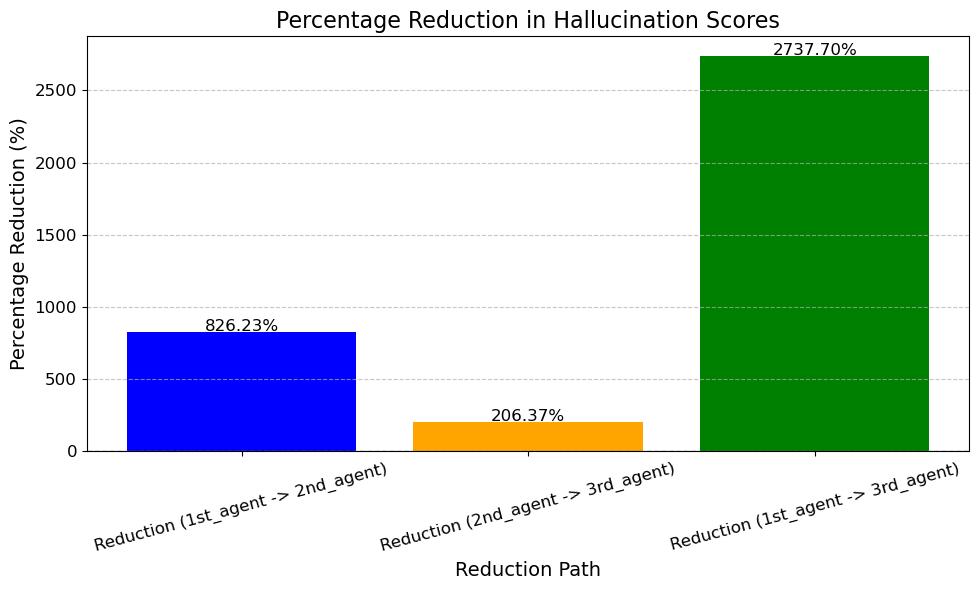

In [12]:
import matplotlib.pyplot as plt

# Plot the percentage reductions
def plot_percentage_reductions(reductions):
    # Extract keys and values for plotting
    labels = list(reductions.keys())
    values = list(reductions.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=["blue", "orange", "green"])

    # Add data labels to the bars
    for i, value in enumerate(values):
        plt.text(i, value + (5 if value > 0 else -5), f"{value:.2f}%", ha="center", fontsize=12, color="black")

    # Customize the plot
    plt.title("Percentage Reduction in Hallucination Scores", fontsize=16)
    plt.xlabel("Reduction Path", fontsize=14)
    plt.ylabel("Percentage Reduction (%)", fontsize=14)
    plt.xticks(fontsize=12, rotation=15)
    plt.yticks(fontsize=12)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Line for no reduction
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Call the plotting function with the reductions dictionary
plot_percentage_reductions(reductions)


In [15]:
# Calculate percentage reductions parametrically
def calculate_percentage_reduction(total_ths):
    # Extract the total scores
    ths1 = total_ths["FrontEndAgent (THS1)"]
    ths2 = total_ths["SecondLevelReviewer (THS2)"]
    ths3 = total_ths["ThirdLevelReviewer (THS3)"]
    
    # Perform calculations
    reduction_first_to_second = ((ths1 - ths2) / abs(ths1)) * 100
    reduction_second_to_third = ((ths2 - ths3) / abs(ths2)) * 100
    reduction_first_to_third = ((ths1 - ths3) / abs(ths1)) * 100
    
    # Return results as a dictionary
    return {
        "(1st_agent -> 2nd_agent)": reduction_first_to_second,
        "(1st_agent -> 3rd_agent)": reduction_first_to_third,
    }

# Total THS from the DataFrame
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Calculate reductions
reductions = calculate_percentage_reduction(total_ths)

# Print results
print("Percentage Reductions:")
for reduction_label, value in reductions.items():
    print(f"{reduction_label}: {value:.2f}%")


Percentage Reductions:
(1st_agent -> 2nd_agent): 826.23%
(1st_agent -> 3rd_agent): 2737.70%


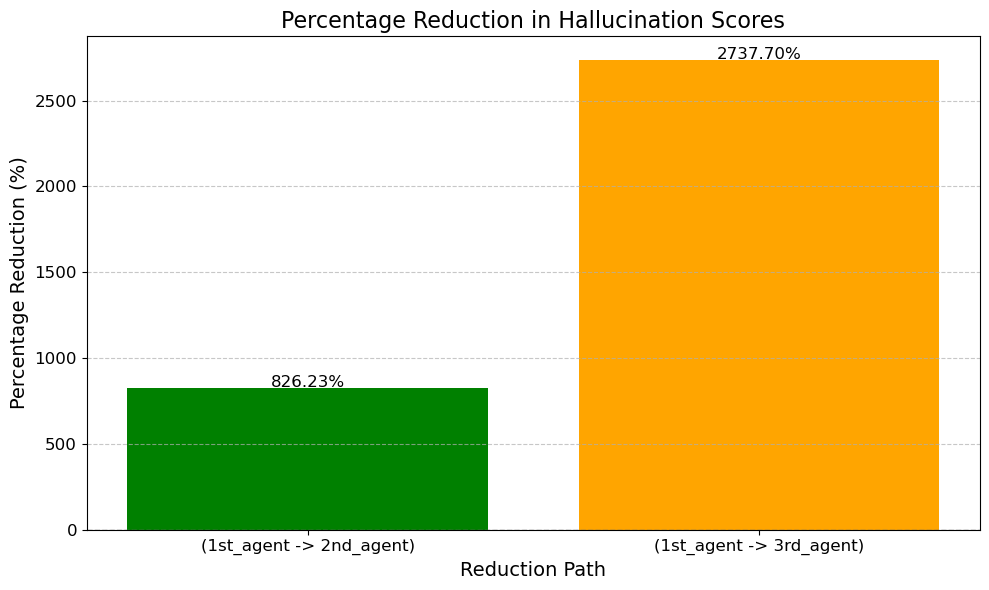

In [18]:
import matplotlib.pyplot as plt

# Plot the percentage reductions
def plot_percentage_reductions(reductions):
    # Extract keys and values for plotting
    labels = list(reductions.keys())
    values = list(reductions.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=["green", "orange", "blue"])

    # Add data labels to the bars
    for i, value in enumerate(values):
        plt.text(i, value + (5 if value > 0 else -5), f"{value:.2f}%", ha="center", fontsize=12, color="black")

    # Customize the plot
    plt.title("Percentage Reduction in Hallucination Scores", fontsize=16)
    plt.xlabel("Reduction Path", fontsize=14)
    plt.ylabel("Percentage Reduction (%)", fontsize=14)
    plt.xticks(fontsize=12, rotation=0)  # Keep labels horizontal by setting rotation to 0
    plt.yticks(fontsize=12)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Line for no reduction
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the plotting function with the reductions dictionary
plot_percentage_reductions(reductions)
